In [2]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023-2024
# see embedded licence file

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import numpy as np

import gpvisc

# CPU or GPU?
device = gpvisc.get_device()

Will run on cuda


# Loading the model

We first load the model using the `load_gp_model`function:

In [3]:
gp_model, likelihood = gpvisc.load_gp_model(model_number=1, device=device)

# Make predictions!

### First example : a single melt composition

To perform such queries, we provide an helper function, `generate_query_single`.

In [4]:
Inputs_ = gpvisc.generate_query_single(sio2=60.0,
                       tio2=0.0,
                       al2o3=9.0,
                       feo=10.0,
                       fe2o3=0.00,
                       mno=0.00,
                       na2o=5.0,
                       k2o=5.0,
                       mgo=10.0,
                       cao=0.0,
                       p2o5=0.00,
                       h2o=0.00,
                       composition_mole=False,
                       control_redox=True,
                       T_init=1050.,
                       T_final=2000.,
                       P_init=0.0,
                       P_final = 0.0,
                       nb_values=50)

Converting weight percent composition to mole fraction...
Calculation iron redox...


If you want to control everything yourself, this can also be done manually like this:

In [5]:
dict_compo = {"sio2":[60.,],
                      "tio2":[0.,],
                      "al2o3":[10.,],
                      "feo":[0.,],
                      "fe2o3":[0.,],
                      "mno":[0.,],
                      "na2o":[5.,],
                      "k2o":[5.,],
                      "mgo":[10.,],
                      "cao":[10.,],
                      "p2o5":[0.,],
                      "h2o":[0.,],
                      }
db = pd.DataFrame(dict_compo)

# check that everything is OK
db = gpvisc.chimie_control(db)

# if you need to convert wt to mol, you can do it using the following command:
#db = gpvisc.wt_mol(db)

#
# for an example of setting the redox, see directly the redox notebook
#
# now we create T and P vectors, custom made
# we will this time use the arange function of numpy to have a T vector with points every degree
# the pressure vector will be created from 0 to 10 GPa, with the same number of elements as T
T_vector = np.arange(1000.0, 1500.0, 1.0)
P_vector = np.linspace(0.,10., len(T_vector))

The db dataset as well as the T_vector and P_vector can then be used in the next function for scaling, as the other dataframe.

Indeed, in all cases a scaling is necessary and we provide a function to do so. 
It takes in inputs vectors of temperature, pressure and an array of oxide fractions. 
The temperature and pressure vectors as well as the compositional array should be of the same length.

In [6]:
tpxi_scaled = gpvisc.scale_for_gaussianprocess( 
                               Inputs_.loc[:,"T"], # temperature input
                               Inputs_.loc[:,"P"], # pressure input
                               Inputs_.loc[:,gpvisc.list_oxides()] # composition input
                               )

We can now make our prediction!

In [7]:
# predictions
visco_mean, visco_std = gpvisc.predict(tpxi_scaled, gp_model, likelihood)

and let's conclude with a nice graph:

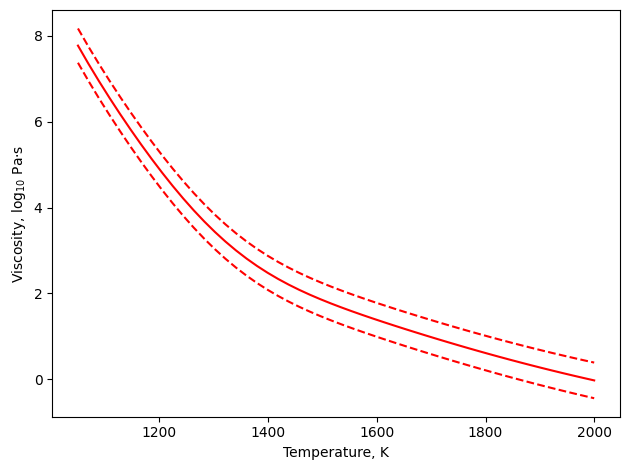

In [8]:
plt.figure()
plt.plot(Inputs_.loc[:,"T"], visco_mean,"r-")
plt.plot(Inputs_.loc[:,"T"], visco_mean-visco_std, "r--")
plt.plot(Inputs_.loc[:,"T"], visco_mean+visco_std, "r--")
plt.xlabel('Temperature, K')
plt.ylabel('Viscosity, log$_{10}$ Pa$\cdot$s')
plt.tight_layout()

## Query for a range of compositions

This can be done with the function `generate_query_range`:

We can then make predictions for a range of compositions at changing or fixed P/T values. We must first indicate the range of oxide components in a Python dictionary like this:

In [9]:
oxide_ranges = {
    'sio2': [50.5, 85.],
    'tio2': [0.0, 0.5],
    'al2o3': [14.7, 13.],
    "feo":[10.4,1.],
    "fe2o3":[0.,0.],
    "mno":[0.,0.],
    "na2o":[2.8,3.4],
    "k2o":[0.2,5.3],
    "mgo":[7.58,0.0],
    "cao":[11.4,0.4],
    "p2o5":[0.0,0.0],
    "h2o":[0.1,5.],
}

Then we can directly query the function `generate_query_range` and make predictions

In [10]:
Inputs_range = gpvisc.generate_query_range(oxide_ranges, composition_mole=False,
                                    T_init=1473, T_final=1073, P_init=1.0, P_final=0.0,
                                    control_redox=True, fo2_init=-7.0, fo2_final=-1.0, nb_values=50)

Converting weight percent composition to mole fraction...
Calculation iron redox...


We transform the data for feeding the GP model using the `gpvisc.scale_for_gaussianprocess` function:

In [11]:
tpxi_scaled = gpvisc.scale_for_gaussianprocess( 
                               Inputs_range["T"], 
                               Inputs_range["P"],
                               Inputs_range[gpvisc.list_oxides()]
                               )

and we make predictions

In [12]:
# predictions
visco_mean, visco_std = gpvisc.predict(tpxi_scaled, gp_model, likelihood)

To conclude, let's do a error bar plot instead of the plot we did earlier, just to showcase the possibility.

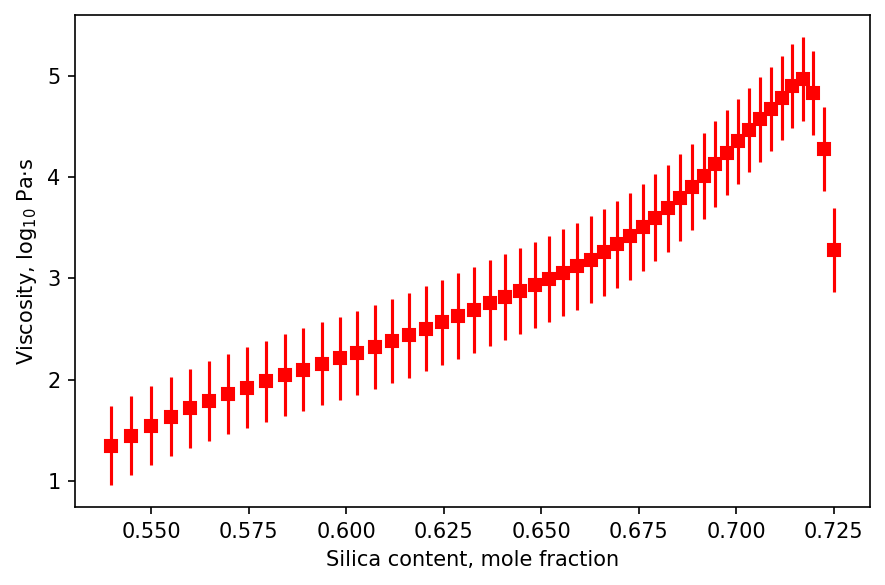

In [13]:

plt.figure(figsize=(6,4), dpi=150)
plt.errorbar(Inputs_range["sio2"], visco_mean, yerr= visco_std, marker="s", c="r", linestyle="none")
plt.xlabel('Silica content, mole fraction')
plt.ylabel('Viscosity, log$_{10}$ Pa$\cdot$s')
plt.tight_layout()